# TRABAJO PRÁCTICO 1: Análisis Exploratorio de Datos

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

plt.style.use('default')
plt.rcParams['figure.figsize'] = (6, 10)
sns.set(style="darkgrid")
%matplotlib inline

my_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
downloaded = drive.CreateFile({'id':"1GKPasgRV2WrBkN2AaeKtvUI01BqvE7MA"})
downloaded.GetContentFile('train.csv')

downloaded = drive.CreateFile({'id':"1adIQXiZazufU25CVBYC3K_yTUl9YNpTg"})
downloaded.GetContentFile('test.csv')

downloaded = drive.CreateFile({'id':"1TmlwXmYSN4Yed0K1Gwtp8SLOYe_GlxuN"})
downloaded.GetContentFile('sample_submissions.csv')


In [0]:
train_df = pd.read_csv('train.csv', encoding='latin-1',dtype={'id': np.uint16,'target': np.bool})

In [5]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,True
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,True
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,True
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",True
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,True


## Tratamiento de datos

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   uint16
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   bool  
dtypes: bool(1), object(3), uint16(1)
memory usage: 200.9+ KB


Podemos observar que las columnas <b><i>"keyword"</i></b> y <b><i>"location"</i></b> poseen algunos valores nulos, vamos a ver si podemos realizar algun tratamiento en particular.

In [7]:
train_df['keyword'].describe()

count           7552
unique           221
top       fatalities
freq              45
Name: keyword, dtype: object

In [0]:
train_df['keyword'].fillna(value='',inplace=True)

In [0]:
train_df['keyword'] = train_df['keyword'].str.replace('%20',' ')

Posiblemente luego analicemos los textos y veamos la posibilidad de completar estos keyword vacios con algun valor mas significativo

In [9]:
train_df['location'].describe()

count     5080
unique    3341
top        USA
freq       104
Name: location, dtype: object

In [10]:
train_df['location'].sample(30)

7085               Milwaukee, WI
2482                         NaN
6911       Gold Coast, Australia
7025             phuket thailand
316                          USA
1112                         NaN
5621                         NaN
904                      Glasgow
3556                         NaN
802                     Scotland
3831                         NaN
7                            NaN
4245                         NaN
6795                      Canada
4543              Sacramento, CA
6867                       World
5942    3000 miles from everyone
4227             Gainesville, FL
3144                Wildomar, CA
4622                         NaN
7186                         NaN
1193                         NaN
690             State of Georgia
4763                         NaN
6642                  Loading...
7560                         NaN
2691                         NaN
4062                         NaN
3184                     Calgary
1043                    Fife, WA
Name: loca

Por ahora dejamos en blanco estos datos, se observa que la ubicacion ingresada no es siempre algo coherente.

## Primeros analisis

In [0]:
train_df['word_count'] = train_df['text'].str.count(' ') + 1
train_df['not_target'] = 0
train_df.loc[train_df['target']==0,'not_target'] = 1

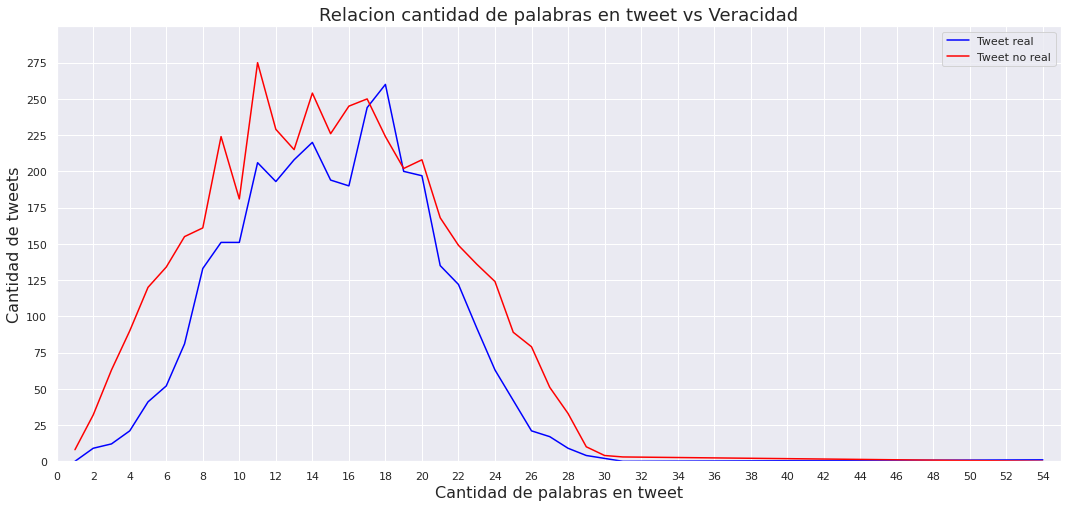

In [12]:
df = train_df.groupby('word_count').agg({'target':'sum','not_target':'sum'}).reset_index()

plt.figure(figsize=(18,8))
ax = sns.lineplot(x='word_count',y='target',data=df,color="blue", label='Tweet real')
ax = sns.lineplot(x='word_count',y='not_target',data=df,color="red", label='Tweet no real')
ax.set_ylim(0,300)
ax.set_yticks(range(0,300,25))
ax.set_xlim(0,55)
ax.set_xticks(range(0,55,2))

ax.set_title('Relacion cantidad de palabras en tweet vs Veracidad', fontsize=18)
ax.set_xlabel('Cantidad de palabras en tweet',fontsize=16)
ax.set_ylabel('Cantidad de tweets', fontsize=16);

## Análisis de la longitud de los tweets

In [0]:
#Creamos una columna con la longitud del tweet.
train_df['longitud_del_tweet'] = train_df['text'].str.len()

In [14]:
#Analizamos las estadísticas de los tweets verdaderos.
train_df[train_df['target']]['longitud_del_tweet'].describe()

count    3271.000000
mean      108.444207
std        29.511567
min        14.000000
25%        88.000000
50%       115.000000
75%       136.000000
max       161.000000
Name: longitud_del_tweet, dtype: float64

In [15]:
#Analizamos las estadísticas de los tweets falsos.
train_df[~train_df['target']]['longitud_del_tweet'].describe()

count    4342.000000
mean       95.981345
std        36.100118
min         7.000000
25%        68.000000
50%       101.000000
75%       130.000000
max       163.000000
Name: longitud_del_tweet, dtype: float64

In [0]:
train_df = train_df.astype({'longitud_del_tweet':np.uint8})

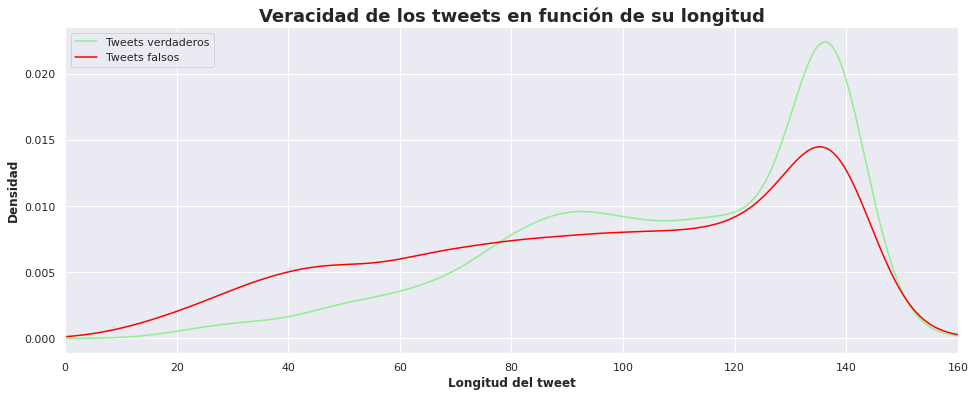

In [17]:
fig= plt.figure()
ax = fig.add_subplot(111)

plt.title('Veracidad de los tweets en función de su longitud',fontsize=18,fontweight='bold')

train_df[train_df['target']]['longitud_del_tweet'].plot.kde(color='lightgreen', figsize=(16, 6), label = 'Tweets verdaderos')
train_df[~train_df['target']]['longitud_del_tweet'].plot.kde(color='red', ax=ax, figsize=(16, 6), label = 'Tweets falsos')

ax.set_xlabel('Longitud del tweet', fontsize=12, fontweight='bold')
ax.set_ylabel('Densidad', fontsize=12, fontweight='bold')

ax.set_xlim(0, 160) #Seteamos los límites del eje x conociendo el valor máximo y mínimo de la longitud de los tweets.
ax.legend()

plt.show()

En está visualización podemos observar que los tweets que tienen una longitud menor a 80 caracteres son en su mayoría falsos, mientras que los que tienen una longitud superior tienden a ser verdaderos. Tambíen podemos ver que la longitud de los tweets tiene un pico llegando a los 140 caracteres, lo cuál tiene sentido considerando las limitaciones que la plataforma solía tener respecto a la longitud de los mismos.

## Análisis de los keywords

Como vimos previamente, la columna keywords tiene **61 registros** con valores nulos. Como es una cantidad pequeña en relación a la cantidad total de registros (**7613 registros**), para este análisis vamos a descartar los registros nulos.

In [18]:
keywords_verdaderos = train_df.loc[~train_df['keyword'].isnull() & train_df['target']]['keyword']
keywords_verdaderos.value_counts()

outbreak       39
derailment     39
wreckage       39
typhoon        37
debris         37
               ..
blazing         1
body bags       1
epicentre       1
electrocute     1
body bag        1
Name: keyword, Length: 220, dtype: int64

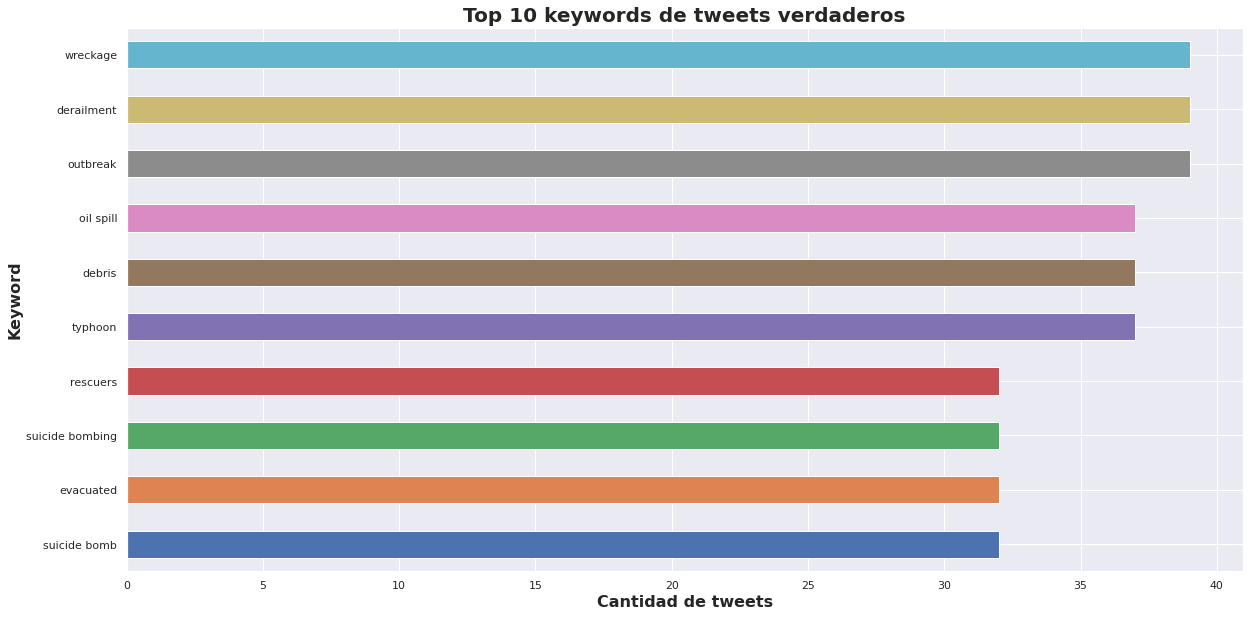

In [19]:
keywords_verdaderos.value_counts().sort_values(ascending=False).head(10).T\
    .sort_values(ascending=True)\
    .plot(figsize=(20,10),kind='barh',rot=0,color=my_colors);

plt.ylabel('Keyword', fontsize=16, fontweight='bold')
plt.title('Top 10 keywords de tweets verdaderos',fontsize=20, fontweight='bold')
plt.xlabel('Cantidad de tweets', fontsize=16, fontweight='bold');

In [20]:
keywords_falsos = train_df.loc[~train_df['keyword'].isnull() & ~train_df['target']]['keyword']
keywords_falsos.value_counts()

body bags          40
armageddon         37
harm               37
ruin               36
wrecked            36
                   ..
suicide bomber      1
outbreak            1
typhoon             1
oil spill           1
suicide bombing     1
Name: keyword, Length: 218, dtype: int64

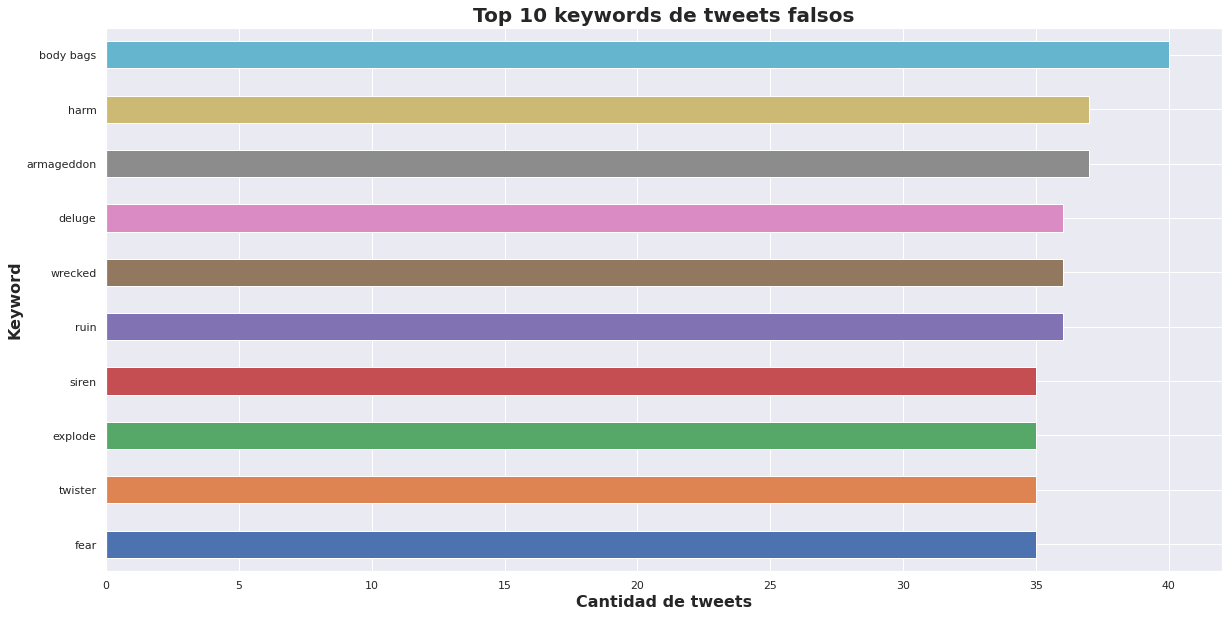

In [21]:
keywords_falsos.value_counts().sort_values(ascending=False).head(10).T\
    .sort_values(ascending=True)\
    .plot(figsize=(20,10),kind='barh',rot=0,color=my_colors);

plt.ylabel('Keyword', fontsize=16, fontweight='bold')
plt.title('Top 10 keywords de tweets falsos',fontsize=20, fontweight='bold')
plt.xlabel('Cantidad de tweets', fontsize=16, fontweight='bold');

## Análisis de menciones

Vamos a analizar la naturaleza de los tweets en base a si se realiza alguna mención en el mismo o no.

In [0]:
train_df['tiene_menciones'] = train_df['text'].str.contains('@')

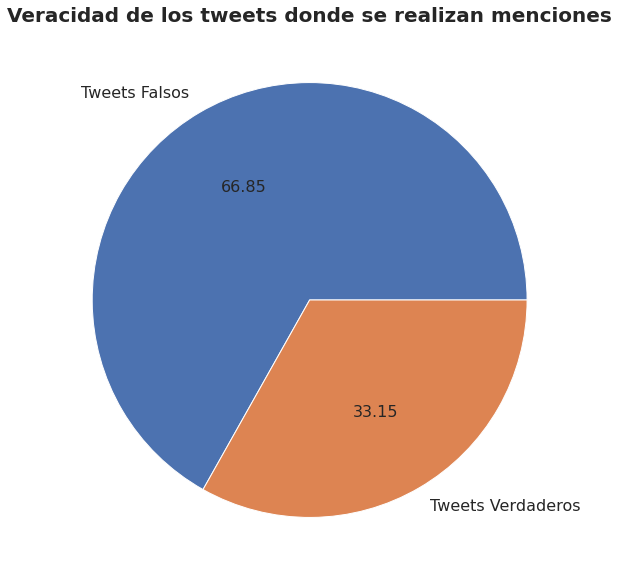

In [23]:
train_df.loc[train_df['tiene_menciones']]['target'].value_counts().plot.pie(labels=['Tweets Falsos',\
                                                        'Tweets Verdaderos'],\
                                                figsize=(10, 10),\
                                                autopct='%.2f', fontsize=16)

plt.ylabel('');
plt.title('Veracidad de los tweets donde se realizan menciones',fontsize=20,weight='bold');

Podemos ver que en 2/3 de los tweets en donde se realiza alguna mención, el tweet resulta ser falso.

## Análisis de hashtags

Vemos si hay alguna relación entre la cantidad de hashtags del tweet y la veracidad del mismo.

In [0]:
train_df['cantidad_de_hashtags'] = train_df['text'].str.count('#')

In [25]:
train_df.groupby(['cantidad_de_hashtags','target']).agg({'id':'count'})

id
cantidad_de_hashtags target      
0                    False   3456
                     True    2396
1                    False    482
                     True     482
2                    False    202
                     True     203
3                    False    108
                     True     100
4                    False     45
                     True      38
5                    False     18
                     True      23
6                    False     19
                     True       7
7                    False      4
                     True       4
8                    False      1
                     True       7
9                    False      2
10                   False      3
                     True       7
11                   False      2
13                   True       4

No aporta nada, esta dividido bastante equitativamente; hay que ver si podemos hacer algo distinto con los hashtags.

## Análisis de "tweets expresivos"

Consideramos como "tweet expresivo" a los tweets en donde se utiliza múltiples signos de exclamación o interrogación consecutivos.

In [0]:
train_df['es_expresivo'] = (train_df['text'].str.contains('\!\!') | train_df['text'].str.contains('\?\?'))

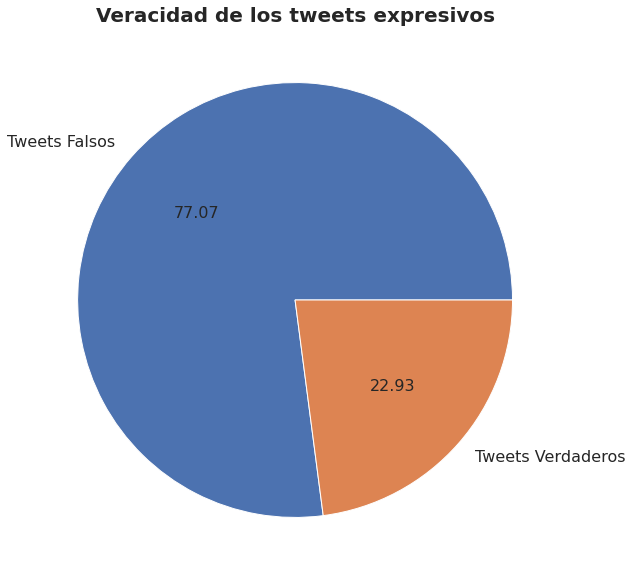

In [27]:
train_df.loc[train_df['es_expresivo']]['target'].value_counts().plot.pie(labels=['Tweets Falsos',\
                                                        'Tweets Verdaderos'],\
                                                figsize=(10, 10),\
                                                autopct='%.2f', fontsize=16)

plt.ylabel('');
plt.title('Veracidad de los tweets expresivos',fontsize=20,weight='bold');

Como podría esperarse, los tweets en donde se utilizan signos de puntuación de manera exagerada, en general para resaltar una emoción del usuario, no suelen ser sobre noticias reales.